In [1]:
import pandas as pd
import numpy as np
import pvlib

In [5]:
# Actual data from HOMER Simulator

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ave_iradiation = [5.11, 5.23, 5.23, 5.15, 4.80, 4.02, 4.05, 3.92, 3.87, 4.54, 4.88, 4.88]
ave_gen = [63.84, 62.44, 66.03, 64.72, 63.01, 65.24, 63.70, 66.60, 65.11, 63.86, 63.24, 64.56]

In [6]:
latitude, longitude = 5.299372048512223, -1.9999535835746673  # UMaT EL Department
tz = 'Africa/Accra'

site = pvlib.location.Location(latitude, longitude, tz=tz)

# A year of hourly solar data
start = pd.Timestamp('2024-01-01', tz=tz)
end = pd.Timestamp('2024-12-31 23:00', tz=tz)
times = pd.date_range(start=start, end=end, freq='h')

# Clear sky irradiance
clearsky = site.get_clearsky(times)

# Scale to match monthly averages
monthly_clearsky = clearsky['ghi'].resample('ME').mean()
scaling_factors = pd.Series(ave_iradiation, index=range(1, 13)) / monthly_clearsky.values

# Apply scaling to get realistic hourly data that matches monthly averages
hourly_irradiance = pd.Series(index=times)
for month, factor in enumerate(scaling_factors, 1):
    mask = times.month == month
    hourly_irradiance[mask] = clearsky['ghi'][mask] * factor

In [7]:
df = pd.DataFrame(index=times)
df['irradiance'] = hourly_irradiance
df['hour'] = df.index.hour
df['month'] = df.index.month


monthly_ave_gen = pd.Series(ave_gen, index=range(1, 13))

# Bbase relationship between irradiance and generation
# The relationship between irradiance and generation isn't perfectly linear:
# 1. It includes system efficiency factors
# 2. Temperature affects efficiency (panels less efficient when hot)
# 3. There's a saturation point at high irradiance

# Method 1: Model based on irradiance with system characteristics
# Calculate efficiency ratio from monthly data
efficiency_ratio = np.array(ave_gen) / np.array(ave_iradiation)
monthly_efficiency = pd.Series(efficiency_ratio, index=range(1, 13))

# Base generation calculation
df['generation'] = df['irradiance'] * 0  # Initialize with zeros

# Apply monthly efficiency patterns with time-of-day adjustments
for month in range(1, 13):
    month_mask = df['month'] == month

    base_efficiency = monthly_efficiency[month]
    
    # Apply efficiency with time-of-day adjustments
    # Morning hours typically have better efficiency (cooler panels)
    for hour in range(24):
        hour_mask = df['hour'] == hour
        combined_mask = month_mask & hour_mask

        # Adjust efficiency by time of day (morning better, afternoon worse due to temperature)
        # Define time factors for different periods of the day
        if hour < 7:  # Early morning, coolest
            time_factor = 1.08
        elif 7 <= hour < 11:  # Morning, still cool
            time_factor = 1.05
        elif 11 <= hour < 15:  # Midday, hottest
            time_factor = 0.92
        else:  # Late afternoon/evening
            time_factor = 0.98

        # Calculate generation with small random variation to simulate real-world conditions
        irradiance_values = df.loc[combined_mask, 'irradiance']
        base_gen = irradiance_values * base_efficiency * time_factor
        
        # Add random variation (system losses, clouds, temperature variations)
        random_factor = np.random.normal(1.0, 0.05, size=len(base_gen))  # 5% variance
        df.loc[combined_mask, 'generation'] = base_gen * random_factor

# Add some system-specific characteristics
# 1. Minimum threshold - very low irradiance produces no power
df.loc[df['irradiance'] < 0.5, 'generation'] = 0

# 2. Saturation at high irradiance levels (inverter clipping)
max_system_output = max(ave_gen) * 1.3  # Assume peak is 30% higher than monthly averages
df.loc[df['generation'] > max_system_output, 'generation'] = max_system_output

# Ensure non-negative generation
df['generation'] = df['generation'].clip(lower=0)

# Scale to match monthly averages
for month in range(1, 13):
    month_mask = df['month'] == month
    current_avg = df.loc[month_mask, 'generation'].mean()
    if current_avg > 0:  # Avoid division by zero
        scaling_factor = ave_gen[month-1] / current_avg
        df.loc[month_mask, 'generation'] *= scaling_factor

In [43]:
print(df["irradiance"][:24])
df

2024-01-01 00:00:00+00:00     0.000000
2024-01-01 01:00:00+00:00     0.000000
2024-01-01 02:00:00+00:00     0.000000
2024-01-01 03:00:00+00:00     0.000000
2024-01-01 04:00:00+00:00     0.000000
2024-01-01 05:00:00+00:00     0.000000
2024-01-01 06:00:00+00:00     0.000000
2024-01-01 07:00:00+00:00     1.299251
2024-01-01 08:00:00+00:00     5.816301
2024-01-01 09:00:00+00:00    10.282444
2024-01-01 10:00:00+00:00    13.894550
2024-01-01 11:00:00+00:00    16.305881
2024-01-01 12:00:00+00:00    17.320671
2024-01-01 13:00:00+00:00    16.860580
2024-01-01 14:00:00+00:00    14.960803
2024-01-01 15:00:00+00:00    11.771408
2024-01-01 16:00:00+00:00     7.572711
2024-01-01 17:00:00+00:00     2.901155
2024-01-01 18:00:00+00:00     0.003392
2024-01-01 19:00:00+00:00     0.000000
2024-01-01 20:00:00+00:00     0.000000
2024-01-01 21:00:00+00:00     0.000000
2024-01-01 22:00:00+00:00     0.000000
2024-01-01 23:00:00+00:00     0.000000
Freq: h, Name: irradiance, dtype: float64


,irradiance,hour,month,generation
2024-01-01 00:00:00+00:00,0.0,0,1,0.0
2024-01-01 01:00:00+00:00,0.0,1,1,0.0
2024-01-01 02:00:00+00:00,0.0,2,1,0.0
2024-01-01 03:00:00+00:00,0.0,3,1,0.0
2024-01-01 04:00:00+00:00,0.0,4,1,0.0
...,...,...,...,...
2024-12-31 19:00:00+00:00,0.0,19,12,0.0
2024-12-31 20:00:00+00:00,0.0,20,12,0.0
2024-12-31 21:00:00+00:00,0.0,21,12,0.0
2024-12-31 22:00:00+00:00,0.0,22,12,0.0


In [9]:
df.describe()

,irradiance,hour,month,generation
count,8784.000000,8784.000000,8784.000000,8784.000000
mean,4.638525,11.500000,6.513661,64.370656
std,6.064125,6.922581,3.451430,74.659999
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,5.750000,4.000000,0.000000
50%,0.000445,11.500000,7.000000,0.000000
75%,10.346110,17.250000,10.000000,158.131729
max,18.287280,23.000000,12.000000,163.251649


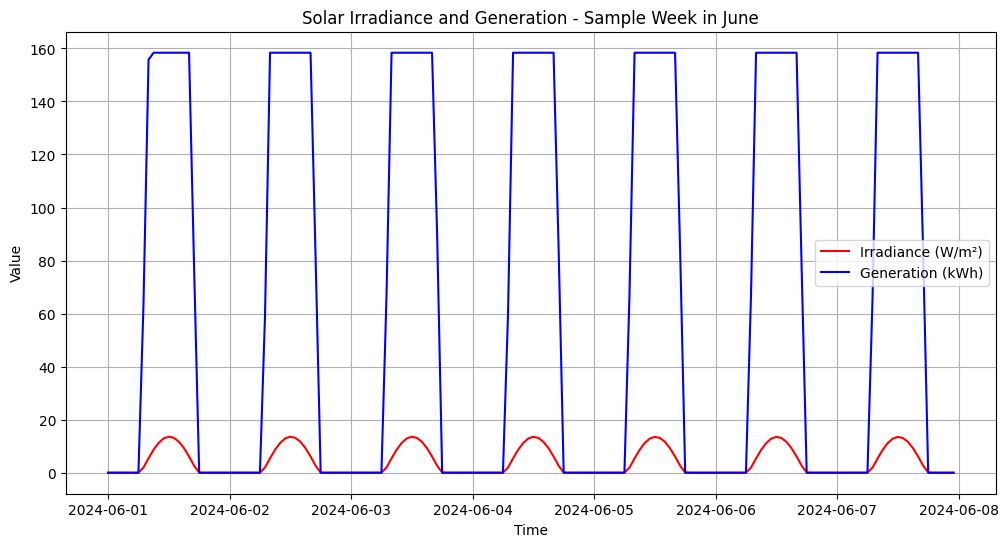

In [10]:
import matplotlib.pyplot as plt

# Plot a week of data to see daily patterns
sample_week = df['2024-06-01':'2024-06-07']
plt.figure(figsize=(12, 6))
plt.plot(sample_week.index, sample_week['irradiance'], 'r-', label='Irradiance (W/m²)')
plt.plot(sample_week.index, sample_week['generation'], 'b-', label='Generation (kWh)')
plt.legend()
plt.title('Solar Irradiance and Generation - Sample Week in June')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Generation Prediction

In [11]:
import xgboost as xgb
import pyswarms as ps
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [12]:
df.isnull().sum()

irradiance    0
hour          0
month         0
generation    0
dtype: int64

In [13]:
def engineer_features(df):
    """Add engineered features to the DataFrame"""
    df_new = df.copy()
    
    # Time-based features using cyclical encoding
    df_new['hour_sin'] = np.sin(2 * np.pi * df_new['hour']/24)
    df_new['hour_cos'] = np.cos(2 * np.pi * df_new['hour']/24)
    df_new['month_sin'] = np.sin(2 * np.pi * df_new['month']/12)
    df_new['month_cos'] = np.cos(2 * np.pi * df_new['month']/12)
    
    # Add day of week and weekend indicator
    df_new['day'] = df_new.index.day
    df_new['day_of_week'] = df_new.index.dayofweek
    df_new['is_weekend'] = df_new['day_of_week'].isin([5, 6]).astype(int)
    
    # Day of year (seasonal feature)
    df_new['day_of_year'] = df_new.index.dayofyear
    df_new['day_of_year_sin'] = np.sin(2 * np.pi * df_new['day_of_year']/365)
    df_new['day_of_year_cos'] = np.cos(2 * np.pi * df_new['day_of_year']/365)
    
    # Square of irradiance (non-linear relationship)
    df_new['irradiance_squared'] = df_new['irradiance'] ** 2
    
    # Irradiance rate of change (if time series)
    df_new['irradiance_diff'] = df_new['irradiance'].diff().fillna(0)
    
    # Lagged features
    df_new['irradiance_lag1'] = df_new['irradiance'].shift(1).fillna(0)
    df_new['irradiance_lag2'] = df_new['irradiance'].shift(2).fillna(0)
    df_new['irradiance_lag3'] = df_new['irradiance'].shift(3).fillna(0)
    df_new['irradiance_lag24'] = df_new['irradiance'].shift(24).fillna(0)
    
    # Time block features (morning, afternoon, etc.)
    df_new['is_daylight'] = ((df_new['hour'] >= 6) & (df_new['hour'] <= 18)).astype(int)
    df_new['is_peak_sun'] = ((df_new['hour'] >= 10) & (df_new['hour'] <= 14)).astype(int)
    
    # Interaction features
    df_new['irradiance_hour'] = df_new['irradiance'] * df_new['hour_sin']
    
    return df_new

In [14]:
df_engineered = engineer_features(df)

In [15]:
# Features that make physical sense for solar generation
features = [
    "irradiance",
    "hour_sin",
    "hour_cos",
    "month_sin",
    "month_cos",
    "day_of_year_sin",
    "day_of_year_cos",
    "is_weekend",
    "is_daylight",
    "is_peak_sun",
    "irradiance_squared",
    "irradiance_diff",
    "irradiance_lag1",
    "irradiance_lag24",
]

X = df_engineered[features]
y = df_engineered["generation"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [18]:
def objective_function(params):
    """
    Objective function for PSO to minimize.
    Returns the negative of the cross-validation score (we minimize the negative of the score)
    """

    max_depth = int(params[0][0])
    learning_rate = params[0][1]
    n_estimators = int(params[0][2])
    subsample = params[0][3]
    colsample_bytree = params[0][4]
    min_child_weight = int(params[0][5])
    gamma = params[0][6]

    model = xgb.XGBRegressor(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        min_child_weight=min_child_weight,
        gamma=gamma,
        random_state=42,
    )

    cv_score = cross_val_score(
        model, X_train_scaled, y_train, cv=5, scoring="neg_mean_squared_error"
    ).mean()

    return -cv_score

In [19]:
# [max_depth, learning_rate, n_estimators, subsample, colsample_bytree, min_child_weight, gamma]
lower_bounds = [3, 0.01, 50, 0.5, 0.5, 1, 0]
upper_bounds = [15, 0.3, 300, 1.0, 1.0, 10, 10]
bounds = (lower_bounds, upper_bounds)

# PSO options
options = {"c1": 0.5, "c2": 0.3, "w": 0.9}

optimizer = ps.single.GlobalBestPSO(
    n_particles=10, dimensions=7, options=options, bounds=bounds
)

In [20]:
print("Running PSO optimization for XGBoost hyperparameters...")
cost, pos = optimizer.optimize(objective_function, iters=50)

2025-03-20 17:23:47,394 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Running PSO optimization for XGBoost hyperparameters...


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=2.71
2025-03-20 17:24:32,845 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.7073372209240523, best pos: [1.03819320e+01 4.88754854e-02 2.27508150e+02 5.32124374e-01
 5.71655040e-01 8.57376242e+00 2.80351861e+00]


In [21]:
best_max_depth = int(pos[0])
best_learning_rate = pos[1]
best_n_estimators = int(pos[2])
best_subsample = pos[3]
best_colsample_bytree = pos[4]
best_min_child_weight = int(pos[5])
best_gamma = pos[6]

print("Best parameters found by PSO:")
print(f"max_depth: {best_max_depth}")
print(f"learning_rate: {best_learning_rate:.4f}")
print(f"n_estimators: {best_n_estimators}")
print(f"subsample: {best_subsample:.2f}")
print(f"colsample_bytree: {best_colsample_bytree:.2f}")
print(f"min_child_weight: {best_min_child_weight}")
print(f"gamma: {best_gamma:.2f}")

Best parameters found by PSO:
max_depth: 10
learning_rate: 0.0489
n_estimators: 227
subsample: 0.53
colsample_bytree: 0.57
min_child_weight: 8
gamma: 2.80


In [22]:
best_model = xgb.XGBRegressor(
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    random_state=42,
)

best_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.5716550400165482), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=np.float64(2.803518605766076), grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=np.float64(0.04887548543226161), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=227, n_jobs=None,
             num_parallel_tree=None, ...)

In [23]:
# Evaluate on test data
y_pred = best_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Model Performance:
Mean Absolute Error: 0.4646
Root Mean Squared Error: 1.5663
R² Score: 0.9996


In [24]:
feature_importance = pd.DataFrame(
    {"Feature": features, "Importance": best_model.feature_importances_}
)
feature_importance = feature_importance.sort_values("Importance", ascending=False)
feature_importance

,Feature,Importance
2,hour_cos,0.368795
10,irradiance_squared,0.333699
0,irradiance,0.193565
13,irradiance_lag24,0.074575
1,hour_sin,0.027362
12,irradiance_lag1,0.000633
4,month_cos,0.000365
3,month_sin,0.000351
6,day_of_year_cos,0.000193
11,irradiance_diff,0.000184


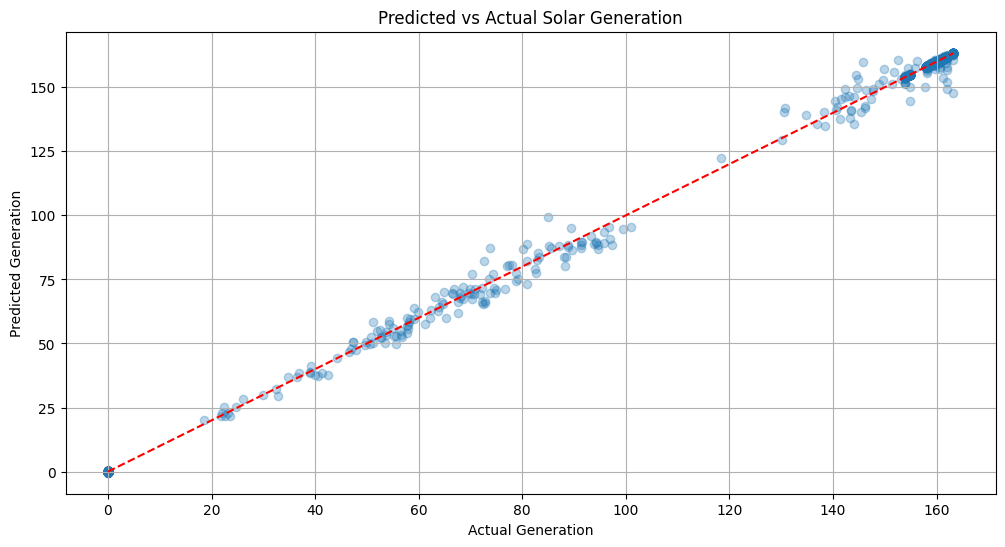

In [25]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Generation")
plt.ylabel("Predicted Generation")
plt.title("Predicted vs Actual Solar Generation")
plt.grid(True)
plt.show()

In [26]:
best_model.save_model("solar_generation_model.json")
print("Model saved as 'solar_generation_model.json'")

Model saved as 'solar_generation_model.json'


In [28]:
def predict_generation(irradiance, datetime_index):
    """
    Predict solar generation given irradiance values and datetime index

    Args:
        irradiance: Array or Series of irradiance values
        datetime_index: Corresponding DatetimeIndex

    Returns:
        Array of predicted generation values
    """

    new_data = pd.DataFrame(
        {
            "irradiance": irradiance,
            "hour": datetime_index.hour,
            "month": datetime_index.month,
        },
        index=datetime_index,
    )

    new_data_engineered = engineer_features(new_data)
    features = [
        "irradiance",
        "hour_sin",
        "hour_cos",
        "month_sin",
        "month_cos",
        "day_of_year_sin",
        "day_of_year_cos",
        "is_weekend",
        "is_daylight",
        "is_peak_sun",
        "irradiance_squared",
        "irradiance_diff",
        "irradiance_lag1",
        "irradiance_lag24",
    ]

    X_new = new_data_engineered[features]
    X_new_scaled = scaler.transform(X_new)

    predictions = best_model.predict(X_new_scaled)

    return predictions

In [44]:
sample_dates = pd.date_range(start="2025-01-01", periods=24, freq="h")
sample_irradiance = [
    0.000000,
    0.000000,
    0.000000,
    0.000000,
    0.000000,
    0.000000,
    0.000000,
    1.299251,
    5.816301,
    10.282444,
    13.894550,
    16.305881,
    17.320671,
    16.860580,
    14.960803,
    11.771408,
    7.572711,
    2.901155,
    0.003392,
    0.000000,
    0.000000,
    0.000000,
    0.000000,
    0.000000,
]

sample_predictions = predict_generation(sample_irradiance, sample_dates)

sample_results = pd.DataFrame(
    {
        "Datetime": sample_dates,
        "Irradiance": sample_irradiance,
        "Predicted_Generation": sample_predictions,
    }
)
sample_results

,Datetime,Irradiance,Predicted_Generation
0,2025-01-01 00:00:00,0.000000,0.001125
1,2025-01-01 01:00:00,0.000000,0.001125
2,2025-01-01 02:00:00,0.000000,0.001125
3,2025-01-01 03:00:00,0.000000,0.001125
4,2025-01-01 04:00:00,0.000000,0.000015
5,2025-01-01 05:00:00,0.000000,0.000211
6,2025-01-01 06:00:00,0.000000,0.132452
7,2025-01-01 07:00:00,1.299251,30.601015
8,2025-01-01 08:00:00,5.816301,142.624268
9,2025-01-01 09:00:00,10.282444,158.844269


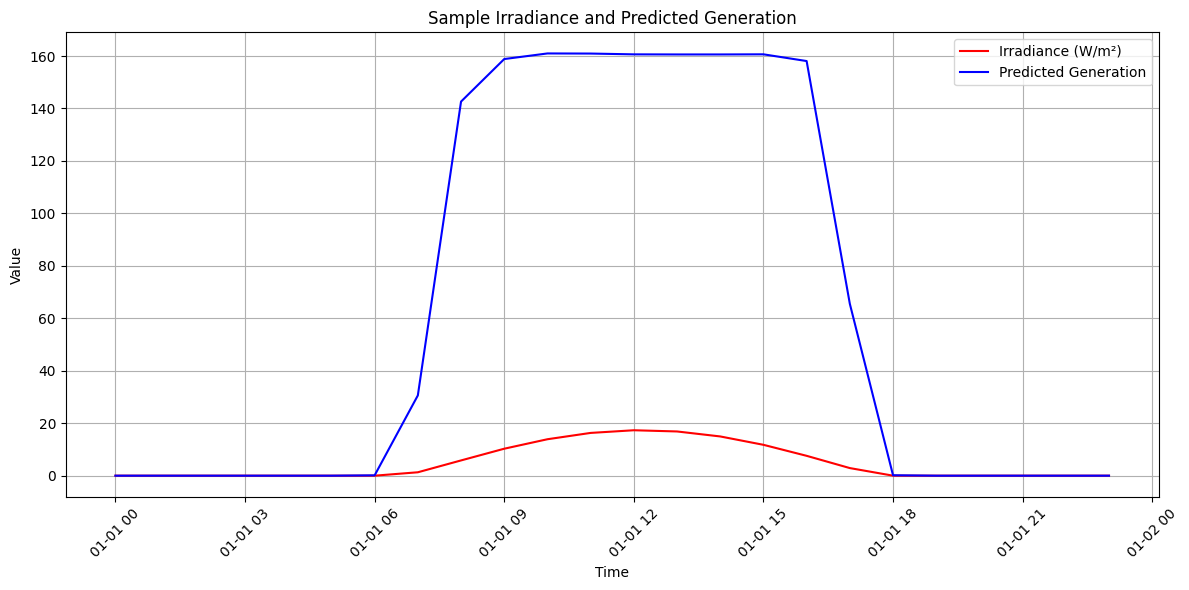

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(sample_dates, sample_irradiance, "r-", label="Irradiance (W/m²)")
plt.plot(sample_dates, sample_predictions, "b-", label="Predicted Generation")
plt.title("Sample Irradiance and Predicted Generation")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()